## 2017 Vine Physiology Analysis

This notebooke contains vine physiology analysisfor the first year of Aim 1 of the NSF/PGRP project "Adapting Perennial Crops for Climate Change: Graft Transmissible Effects of Rootstocks on Grapevine Shoots" (1546869). The manuscript(s) associated with the data can be found in the README of this GitHIb repository.

This code is provided for reproducability.

Questions about this code and project can be directed to Zachary N. Harris or Allison J. Miller.

In [1]:
library('tidyverse') ## Some functions get masked here. So it is worth being explicit for gather, select
library('rebus')
library('viridis')
library('dplyr') ## ## Some functions get masked here. So it is worth being explicit for gather, select
library('tibble')
library('anomalize')
library('car')
library('emmeans')

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.1     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘rebus’

The following object is masked from ‘package:stringr’:

    regex

The following object is masked from ‘package:ggplot2’:

    alpha

Loading required package: viridisLite
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some



In [2]:
meta <- read.csv('2017_treatment_metadata.csv')
head(meta)

sampleName,fileName,Row,Rootstock,Irrigation,Phenology,Tissue,Block
<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
A1Y1_001_L,A1Y1_001_L.counts,8,1103P,none,anthesis,Leaf,A
A1Y1_001_R,A1Y1_001_R.counts,8,1103P,none,anthesis,Reproductive,A
A1Y1_002_L,A1Y1_002_L.counts,8,1103P,none,anthesis,Leaf,A
A1Y1_002_R,A1Y1_002_R.counts,8,1103P,none,anthesis,Reproductive,A
A1Y1_003_L,A1Y1_003_L.counts,8,3309C,none,anthesis,Leaf,A
A1Y1_003_R,A1Y1_003_R.counts,8,3309C,none,anthesis,Reproductive,A


In [3]:
df <- read.csv('2017_physiology_clean_RNAseqNames_sMfixedVeraison.csv')
df <- df %>% dplyr::select(sampleName, Row:soilMoisture, Cond:Trmmol)
df <- head(df, 216)
head(df)

sampleName,Row,block,vine,waterPotential,soilMoisture,Cond,Ci,Trmmol
<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1Y1_001_L,8,a,2,9.50,32.0,0.07734387,138.1123,0.9736491
A1Y1_002_L,8,a,3,12.50,35.4,0.10386962,168.9603,1.1339703
A1Y1_003_L,8,b,2,12.60,34.8,0.03543027,-147.5891,0.3974592
A1Y1_004_L,8,b,3,10.50,35.4,0.33619481,258.1799,2.6348604
A1Y1_005_L,8,c,2,8.00,33.4,0.12829633,166.6581,1.0702814
A1Y1_006_L,8,c,3,10.75,33.4,0.27706389,281.0614,3.6145544


In [4]:
df <- merge(df, meta, on='sampleName', how='left')
df$Row <- as.factor(df$Row)
head(df)

sampleName,Row,block,vine,waterPotential,soilMoisture,Cond,Ci,Trmmol,fileName,Rootstock,Irrigation,Phenology,Tissue,Block
<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
A1Y1_001_L,8,a,2,9.50,32.0,0.07734387,138.1123,0.9736491,A1Y1_001_L.counts,1103P,none,anthesis,Leaf,A
A1Y1_002_L,8,a,3,12.50,35.4,0.10386962,168.9603,1.1339703,A1Y1_002_L.counts,1103P,none,anthesis,Leaf,A
A1Y1_003_L,8,b,2,12.60,34.8,0.03543027,-147.5891,0.3974592,A1Y1_003_L.counts,3309C,none,anthesis,Leaf,A
A1Y1_004_L,8,b,3,10.50,35.4,0.33619481,258.1799,2.6348604,A1Y1_004_L.counts,3309C,none,anthesis,Leaf,A
A1Y1_005_L,8,c,2,8.00,33.4,0.12829633,166.6581,1.0702814,A1Y1_005_L.counts,SO4,none,anthesis,Leaf,A
A1Y1_006_L,8,c,3,10.75,33.4,0.27706389,281.0614,3.6145544,A1Y1_006_L.counts,SO4,none,anthesis,Leaf,A


### Data Summary

In [5]:
table(df$Row)
table(df$Block)
table(df$Rootstock)
table(df$Irrigation)
table(df$Phenology)


 8  9 10 11 12 13 14 15 16 
24 24 24 24 24 24 24 24 24 


 A  B  C 
72 72 72 


1103P 3309C   Own   SO4 
   54    54    54    54 


full none  RDI 
  72   72   72 


anthesis  harvest veraison 
      72       72       72 

In [6]:
# decide which variables to model
vars <- c('Ci', 'Cond', 'Trmmol', 'waterPotential')

# create a collector for models and anovas
models <- list(rep(0, length(vars)))
anovas <- list(rep(0, length(vars)))

# change options for the lms
oldc <- getOption("contrasts")
options(contrasts=c('contr.sum','contr.poly'))

pdf('2017_physiology_distributions.pdf', onefile=T)
# do stats
for (idx in 1:length(vars)){
    # get var name at index
    variable <- vars[idx]
    
    # plot raw data
    d <- df[,c('sampleName', 'Irrigation', 'Rootstock', 'Phenology', 'Block', variable)]
    p <- ggplot(d, aes_string(variable)) + geom_density() + geom_rug() + ggtitle(paste(variable, 'raw', sep='_'))
    print(p)
    
    # remove outliers and plot clean data
    d <- anomalize(as_tibble(d), target=variable, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    p <- ggplot(d, aes_string(variable)) + geom_density() + geom_rug() + ggtitle(paste(variable, 'clean', sep='_'))
    print(p)
    
    # fit lms
    colnames(d) <- c('sampleName', 'Irrigation', 'Rootstock', 'Phenology', 'Block', 'variable')
    model <- lm(variable ~ Block + Irrigation + Rootstock + Phenology + Block:Rootstock + Block:Phenology + Rootstock:Phenology, data=d, singular.ok=TRUE)
    models[[idx]] <- model
    
    # compute stats on model under type-3 SS
    stats <- car::Anova(model, type=3)
    anovas[[idx]] <- stats
    
}
dev.off()

# reset base contrasts so nothing is too broken
options(contrasts = oldc)

Warning message:
“Removed 1 rows containing non-finite values (stat_density).”Warning message:
“Removed 1 rows containing non-finite values (stat_density).”Warning message:
“Removed 1 rows containing non-finite values (stat_density).”Warning message:
“Removed 1 rows containing non-finite values (stat_density).”Warning message:
“Removed 1 rows containing non-finite values (stat_density).”Warning message:
“Removed 1 rows containing non-finite values (stat_density).”

png 
  2

In [7]:
anovas[[2]]

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),9.5014170248,1,2489.6959751,9.241184e-111
Block,0.0180594159,2,2.3660921,9.662128e-02
Irrigation,0.0008815091,2,0.1154927,8.909899e-01
Rootstock,0.0343785963,3,3.0027890,3.173327e-02
Phenology,0.1557318699,2,20.4035361,9.479822e-09
Block:Rootstock,0.0332215081,6,1.4508617,1.973514e-01
Block:Phenology,0.0807019644,4,5.2866682,4.664862e-04
Rootstock:Phenology,0.0795471995,6,3.4740141,2.792824e-03
Residuals,0.7212799617,189,NA,NA


In [8]:
range

function (..., na.rm = FALSE)  .Primitive("range")

In [9]:
factors <- rownames(anovas[[1]])[2:length(rownames(anovas[[1]]))]

total_var_mat_p=matrix(,length(vars),length(factors)*2)
colnames(total_var_mat_p) <- c(factors, paste(factors, 'p', sep='_'))
rownames(total_var_mat_p) <- vars

for (idx in 1:length(vars)){
    range <- 2:(length(factors)+1)
    SS <- anovas[[idx]]$Sum[range]
    total_var <- sum(SS, na.rm=TRUE)
    var_exp <- SS/total_var * 100
    var_p <- anovas[[idx]]$Pr[range]
    mat_row <- c(var_exp, var_p)
    total_var_mat_p[idx,] <- mat_row
}

head(total_var_mat_p)

,Block,Irrigation,Rootstock,Phenology,Block:Rootstock,Block:Phenology,Rootstock:Phenology,Residuals,Block_p,Irrigation_p,Rootstock_p,Phenology_p,Block:Rootstock_p,Block:Phenology_p,Rootstock:Phenology_p,Residuals_p
Ci,0.7180035,1.24542625,0.5129583,3.774457,2.941898,12.272552,4.7520235,73.78268,4.023944e-01,0.20732969,0.72771791,9.189035e-03,0.2830626,7.536720e-06,0.065211137,NA
Cond,1.6069926,0.07843989,3.0591328,13.857589,2.956171,7.181155,7.0783997,64.18212,9.662128e-02,0.89098986,0.03173327,9.479822e-09,0.1973514,4.664862e-04,0.002792824,NA
Trmmol,4.2226406,0.10141415,1.4405043,52.911636,1.026380,12.337828,2.4952867,25.46431,5.047978e-07,0.68687139,0.01526085,7.249225e-47,0.2732102,1.942141e-15,0.006610057,NA
waterPotential,0.8453954,1.66065748,0.9110301,27.117017,2.147778,7.190498,0.8575603,59.27006,2.604213e-01,0.07242895,0.40637164,2.862374e-16,0.3364742,2.128252e-04,0.838555576,NA


In [10]:
total_var_mat_p <- data.frame(total_var_mat_p)

total_var_mat_p$variable <- rownames(total_var_mat_p)
total_var_mat_p$Residuals <- NULL
total_var_mat_p$Residuals_p <- NULL

head(total_var_mat_p)

write.csv(total_var_mat_p, file='2017_physiology_var_p.csv', quote=F)

,Block,Irrigation,Rootstock,Phenology,Block.Rootstock,Block.Phenology,Rootstock.Phenology,Block_p,Irrigation_p,Rootstock_p,Phenology_p,Block.Rootstock_p,Block.Phenology_p,Rootstock.Phenology_p,variable
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Ci,0.7180035,1.24542625,0.5129583,3.774457,2.941898,12.272552,4.7520235,4.023944e-01,0.20732969,0.72771791,9.189035e-03,0.2830626,7.536720e-06,0.065211137,Ci
Cond,1.6069926,0.07843989,3.0591328,13.857589,2.956171,7.181155,7.0783997,9.662128e-02,0.89098986,0.03173327,9.479822e-09,0.1973514,4.664862e-04,0.002792824,Cond
Trmmol,4.2226406,0.10141415,1.4405043,52.911636,1.026380,12.337828,2.4952867,5.047978e-07,0.68687139,0.01526085,7.249225e-47,0.2732102,1.942141e-15,0.006610057,Trmmol
waterPotential,0.8453954,1.66065748,0.9110301,27.117017,2.147778,7.190498,0.8575603,2.604213e-01,0.07242895,0.40637164,2.862374e-16,0.3364742,2.128252e-04,0.838555576,waterPotential


In [ ]:
# Get variance columns
total_var <- total_var_mat_p %>% dplyr::select(variable, Irrigation:Rootstock.Phenology)

# reorganize and rename to format for plotting
total_var <- total_var %>% gather(key=factor, value=var, -variable)

total_var <- total_var %>% mutate(factor=str_replace(factor, "_var" %R% END, ""))
head(total_var)

#get p-value columns
total_p <- total_var_mat_p %>% dplyr::select(Irrigation_p:Rootstock.Phenology_p)
total_p <- data.frame(t(apply(total_p, 1, FUN=p.adjust, method='fdr')))
total_p$variable <- total_var_mat_p$variable

#reorganize and rename to format for plotting
total_p <- total_p %>% gather(key=factor, value=p_value, -variable)
total_p <- total_p %>% mutate(factor=str_replace(factor,"_p" %R% END, ""))

#join variance and p-value tables back together 
total_var_p <- full_join(total_var, total_p,by=c("variable", "factor"))

#elements need a number for y-axis when plotting 
total_var_p <- total_var_p %>% arrange(variable) %>% mutate(var_number=rep(1:4, each=6))

#only plot significant p_values
total_var_p_sig <- total_var_p %>% filter(p_value < 0.05) 
write.table(total_var_p_sig[,c("variable", "factor","var", "p_value")], "2017_physiology_var_p_sig.txt", sep="\t", row.names=F, quote=F, col.names=T)

In [46]:
#make plot
 
total_var_p_sig$factor <- factor(total_var_p_sig$factor, levels=c('Phenology', 'Rootstock', 'Block.Phenology', 'Rootstock.Phenology'))

png 
  2

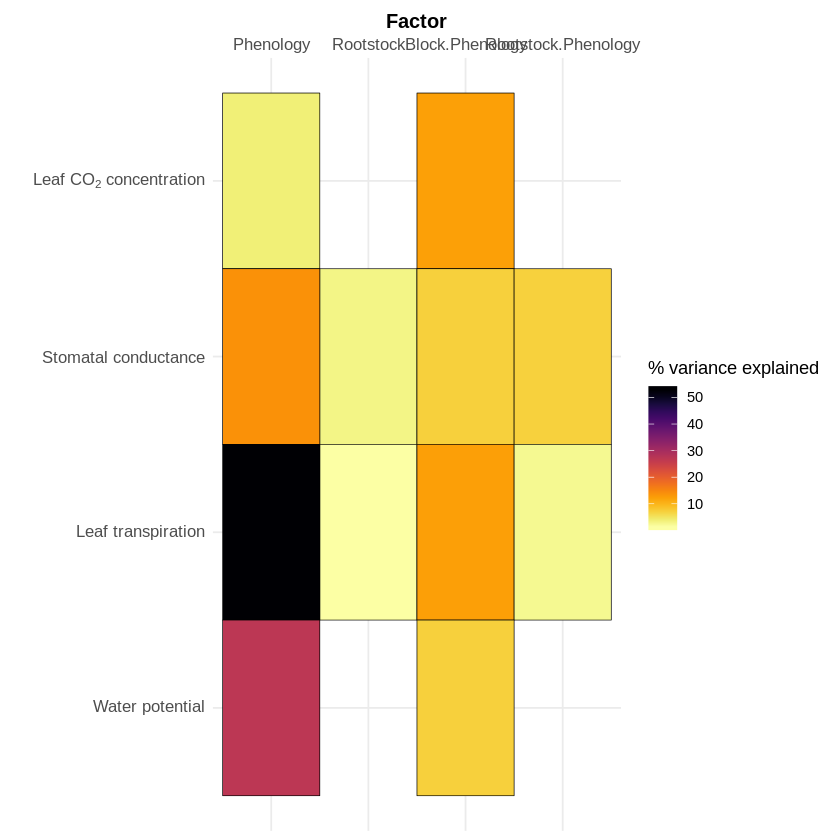

In [47]:
t <- ggplot(data=total_var_p_sig, aes(x=factor, y=as.numeric(as.character(var_number)), fill=var)) + 
    geom_tile(color="black", size=0.2)+
    theme_minimal() +
    labs(x = "Factor", y="") + 
    theme(axis.text=element_text(size=10),axis.title=element_text(size=12,face="bold"),legend.position = "right") +
    scale_y_continuous(trans="reverse", breaks = seq(1, 4, 1), minor_breaks=NULL, labels=c(bquote('Leaf '*CO[2]*' concentration'), 'Stomatal conductance', 'Leaf transpiration', ' Water potential')) + #unique(total_var_p_sig[,"variable"])) +
    scale_x_discrete(position = "top") + 
    scale_fill_viridis(option="inferno", name="% variance explained", direction = -1)


t

pdf("physiology_variance_heatmap_black_viridis.pdf", width=12, height=8)
  t
dev.off()

In [12]:
for (i in 1:length(anovas)){
    print(c('Ci', 'Cond', 'Trmmol', 'waterPotential')[i])
    print(anovas[[i]])
}

[1] "Ci"
Anova Table (Type III tests)

Response: variable
                      Sum Sq  Df    F value    Pr(>F)    
(Intercept)         14494697   1 18420.5100 < 2.2e-16 ***
Block                   1440   2     0.9147  0.402394    
Irrigation              2497   2     1.5867  0.207330    
Rootstock               1028   3     0.4357  0.727718    
Phenology               7568   2     4.8087  0.009189 ** 
Block:Rootstock         5898   6     1.2493  0.283063    
Block:Phenology        24606   4     7.8177 7.537e-06 ***
Rootstock:Phenology     9528   6     2.0180  0.065211 .  
Residuals             147933 188                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Cond"
Anova Table (Type III tests)

Response: variable
                    Sum Sq  Df   F value    Pr(>F)    
(Intercept)         9.5014   1 2489.6960 < 2.2e-16 ***
Block               0.0181   2    2.3661 0.0966213 .  
Irrigation          0.0009   2    0.1155 0.8909899    
Rootstock      

In [13]:
## Comparison of means for Trmmol and Cond for RS x P

cond_model <- models[[2]]
trmmol_model <- models[[3]]

cond.emm <- emmeans(cond_model, ~Rootstock:Phenology)
res <- pairs(cond.emm)
res <- as.data.frame(res)
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = ",", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = ",", names = c('i2', 'p2')))
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.p1 == res$c2.p2,] %>% select(contrast:p.value)
res$padj <- p.adjust(res$p.value, method='fdr')
res[res$padj < 0.05,]

trmmol.emm <- emmeans(trmmol_model, ~Rootstock:Phenology)
res <- pairs(trmmol.emm)
res <- as.data.frame(res)
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = ",", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = ",", names = c('i2', 'p2')))
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.p1 == res$c2.p2,] %>% select(contrast:p.value)
res$padj <- p.adjust(res$p.value, method='fdr')
res[res$padj < 0.05,]

,contrast,estimate,SE,df,t.ratio,p.value,padj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
62,"1103P,veraison - Own,veraison",0.1030994,0.02091467,189,4.929523,0.0001124028,0.002023251


,contrast,estimate,SE,df,t.ratio,p.value,padj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
62,"1103P,veraison - Own,veraison",2.230034,0.4417889,189,5.047736,6.598567e-05,0.001187742


In [14]:
ci.emm <- emmeans(models[[1]], ~Block:Phenology)
res <- pairs(ci.emm)
res <- as.data.frame(res)
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = ",", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = ",", names = c('i2', 'p2')))
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.p1 == res$c2.p2,] %>% select(contrast:p.value)
res$padj <- p.adjust(res$p.value, method='fdr')
res[res$padj < 0.05,]


cond.emm <- emmeans(cond_model, ~Block:Phenology)
res <- pairs(cond.emm)
res <- as.data.frame(res)
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = ",", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = ",", names = c('i2', 'p2')))
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.p1 == res$c2.p2,] %>% select(contrast:p.value)
res$padj <- p.adjust(res$p.value, method='fdr')
res[res$padj < 0.05,]

trmmol.emm <- emmeans(trmmol_model, ~Block:Phenology)
res <- pairs(trmmol.emm)
res <- as.data.frame(res)
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = ",", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = ",", names = c('i2', 'p2')))
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.p1 == res$c2.p2,] %>% select(contrast:p.value)
res$padj <- p.adjust(res$p.value, method='fdr')
res[res$padj < 0.05,]

wP.emm <- emmeans(models[[4]], ~Block:Phenology)
res <- pairs(wP.emm)
res <- as.data.frame(res)
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = ",", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = ",", names = c('i2', 'p2')))
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.p1 == res$c2.p2,] %>% select(contrast:p.value)
res$padj <- p.adjust(res$p.value, method='fdr')
res[res$padj < 0.05,]

,contrast,estimate,SE,df,t.ratio,p.value,padj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
23,"A,harvest - C,harvest",35.76962,8.097727,188,4.417242,0.0005621473,0.002529663
27,"B,harvest - C,harvest",37.26048,8.097727,188,4.601350,0.0002611489,0.002350340


contrast,estimate,SE,df,t.ratio,p.value,padj
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


,contrast,estimate,SE,df,t.ratio,p.value,padj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
22,"A,harvest - B,harvest",1.862093,0.3766987,189,4.943188,5.852663e-05,1.755799e-04
23,"A,harvest - C,harvest",4.103316,0.3766987,189,10.892832,0.000000e+00,0.000000e+00
27,"B,harvest - C,harvest",2.241223,0.3766987,189,5.949644,4.562499e-07,2.053124e-06


contrast,estimate,SE,df,t.ratio,p.value,padj
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


## Graphs

In [17]:
rs_c_pal <- c("gray","#1b9e77", "#7570b3", "#e6ab02")

pdf('2017_physiology_boxplots_rs_phenology.pdf', onefile=T)
for (idx in 1:length(vars)){
    # get element name at index
    element <- vars[idx]
    
    # get raw data
    d <- df[,c('sampleName', 'Irrigation', 'Block', 'Rootstock', 'Phenology', element)]
    
    # remove outliers
    d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    d <- d %>% mutate(Rootstock = fct_relevel(Rootstock, "Own","1103P", "3309C", "SO4"),
                      Phenology = fct_relevel(Phenology, "anthesis", "veraison", "harvest"))
    levels(d$Phenology) <- c('Anthesis', 'Veraison', 'Harvest')
    p <- ggplot(d, aes_string(x='Rootstock', y=element, fill='Rootstock')) + 
         geom_boxplot() +
         scale_fill_manual(name='Rootstock', values=rs_c_pal, labels=c('Ungrafted', '1103P', '3309C', 'SO4')) +
         scale_x_discrete(name='Rootstock', labels=c('Ungrafted', '1103P', '3309C', 'SO4')) + 
         facet_wrap('Phenology') + theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    print(p)
}
dev.off()

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

png 
  2

In [165]:
pdf('2017_physiology_boxplots_rs.pdf', onefile=T)
for (idx in 1:length(vars)){
    # get element name at index
    element <- vars[idx]
    
    # get raw data
    d <- df[,c('sampleName', 'Irrigation', 'Block', 'Rootstock', 'Phenology', element)]
    
    # remove outliers
    d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    d <- d %>% mutate(Rootstock = fct_relevel(Rootstock, "Own","1103P", "3309C", "SO4"),
                      Phenology = fct_relevel(Phenology, "anthesis", "veraison", "harvest"))
    p <- ggplot(d, aes_string(x='Rootstock', y=element, fill='Rootstock')) + 
         geom_boxplot() +
         scale_fill_manual(name='Rootstock', values=rs_c_pal, labels=c('Ungrafted', '1103P', '3309C', 'SO4')) +
         scale_x_discrete(name='Rootstock', labels=c('Ungrafted', '1103P', '3309C', 'SO4')) + 
         theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    print(p)
}
dev.off()

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

png 
  2

In [166]:
time_c_pal <- c('orchid1', 'purple1', 'darkorchid4')

pdf('2017_physiology_boxplots_phenology.pdf', onefile=T)
for (idx in 1:length(vars)){
    # get element name at index
    element <- vars[idx]
    
    # get raw data
    d <- df[,c('sampleName', 'Irrigation', 'Block', 'Rootstock', 'Phenology', element)]
    
    # remove outliers
    d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    d <- d %>% mutate(Phenology = fct_relevel(Phenology, "anthesis", "veraison", "harvest"))
    p <- ggplot(d, aes_string(x='Phenology', y=element, fill='Phenology')) + 
         geom_boxplot() +
         scale_fill_manual(name='Phenology', values=time_c_pal, labels=c('Anthesis', 'Veraison', 'Harvest')) +
         scale_x_discrete(name='Phenology', labels=c('Anthesis', 'Veraison', 'Harvest')) + 
         theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    print(p)
}
dev.off()

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

png 
  2

In [167]:
block_pal <- c('#ffd4a3', '#ffaa5e', '#d08159')

pdf('2017_physiology_boxplots_block.pdf', onefile=T)
for (idx in 1:length(vars)){
    # get element name at index
    element <- vars[idx]
    
    # get raw data
    d <- df[,c('sampleName', 'Irrigation', 'Block', 'Rootstock', 'Phenology', element)]
    
    # remove outliers
    d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    d <- d %>% mutate(Phenology = fct_relevel(Phenology, "anthesis", "veraison", "harvest"))
    p <- ggplot(d, aes_string(x='Block', y=element, fill='Block')) + 
         geom_boxplot() +
         scale_fill_manual(name='Block', values=block_pal, labels=c('A', 'B', 'C')) +
         scale_x_discrete(name='Block', labels=c('A', 'B', 'C')) + 
         theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 0, hjust = 1))
    print(p)
}
dev.off()

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

png 
  2

In [168]:
block_pal <- c('#ffd4a3', '#ffaa5e', '#d08159')

pdf('2017_physiology_boxplots_block_phenology.pdf', onefile=T)
for (idx in 1:length(vars)){
    # get element name at index
    element <- vars[idx]
    
    # get raw data
    d <- df[,c('sampleName', 'Irrigation', 'Block', 'Rootstock', 'Phenology', element)]
    
    # remove outliers
    d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    d <- d %>% mutate(Phenology = fct_relevel(Phenology, "anthesis", "veraison", "harvest"))
    p <- ggplot(d, aes_string(x='Block', y=element, fill='Block')) + 
         geom_boxplot() +
         scale_fill_manual(name='Block', values=block_pal, labels=c('A', 'B', 'C')) +
         scale_x_discrete(name='Block', labels=c('A', 'B', 'C')) + 
         theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 0, hjust = 1)) + 
    facet_wrap('Phenology') + theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    print(p)
}
dev.off()

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

png 
  2

## Main Physiology Figure

In [48]:
physFigA <- t

d <- df[,c('sampleName', 'Block', 'Rootstock', 'Phenology', 'Trmmol')]
# remove outliers
d <- anomalize(as_tibble(d), target=Trmmol, method='iqr', alpha=0.03, max_anoms=0.1)
d <- d[d$anomaly != 'Yes',]
d$Phenology <- factor(d$Phenology, levels=c('anthesis', 'veraison', 'harvest'), labels=c('Anthesis', 'Veraison', 'Harvest'))
d$Rootstock <- factor(d$Rootstock, levels=c('Own', '1103P', '3309C', 'SO4'), labels=c('Ungrafted', '1103P', '3309C', 'SO4'))


physFigB <- ggplot(d, aes_string(x='Rootstock', y='Trmmol', fill='Rootstock')) + 
     geom_boxplot() +
     scale_fill_manual(name='Rootstock', values=rs_c_pal, labels=c('Ungrafted', '1103P', '3309C', 'SO4')) +
     scale_x_discrete(name='Rootstock', labels=c('Ungrafted', '1103P', '3309C', 'SO4')) + 
     ylab(bquote('Leaf Transpiration Rate (mmol' ~H[2]* 'O' ~m^-2 ~s^-1*')')) + 
     facet_wrap('Phenology') +
     theme_bw() + 
     theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) +  
     theme(axis.text.x = element_text(angle = 45, hjust = 1))
           
d <- df[,c('sampleName', 'Block', 'Rootstock', 'Phenology', 'Cond')]
# remove outliers
d <- anomalize(as_tibble(d), target=Cond, method='iqr', alpha=0.03, max_anoms=0.1)
d <- d[d$anomaly != 'Yes',]
d$Phenology <- factor(d$Phenology, levels=c('anthesis', 'veraison', 'harvest'), labels=c('Anthesis', 'Veraison', 'Harvest'))
d$Rootstock <- factor(d$Rootstock, levels=c('Own', '1103P', '3309C', 'SO4'), labels=c('Ungrafted', '1103P', '3309C', 'S04'))

physFigC <- ggplot(d, aes_string(x='Rootstock', y='Cond', fill='Rootstock')) + 
     geom_boxplot() +
     scale_fill_manual(name='Rootstock', values=rs_c_pal) +
     scale_x_discrete(name='Rootstock')+
     ylab(bquote('Stomatal Conductance ('*~mol ~m^-2 ~s^-1*')')) + 
     theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 0, hjust = 1)) + 
     facet_wrap('Phenology') + theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 45, hjust = 1))

tmp <- ggpubr::ggarrange(physFigB, physFigC, labels=c('B', 'C'), ncol=2, nrow=1, common.legend=T, legend='right')

pdf('2017_physiology_mainFigure_2.pdf', width=8, height=8)
   ggpubr::ggarrange(physFigA, tmp, labels=c('A', ''), ncol=1, nrow=2, legend='right')
dev.off()

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

png 
  2

## Supplmental Note Figures and Stats

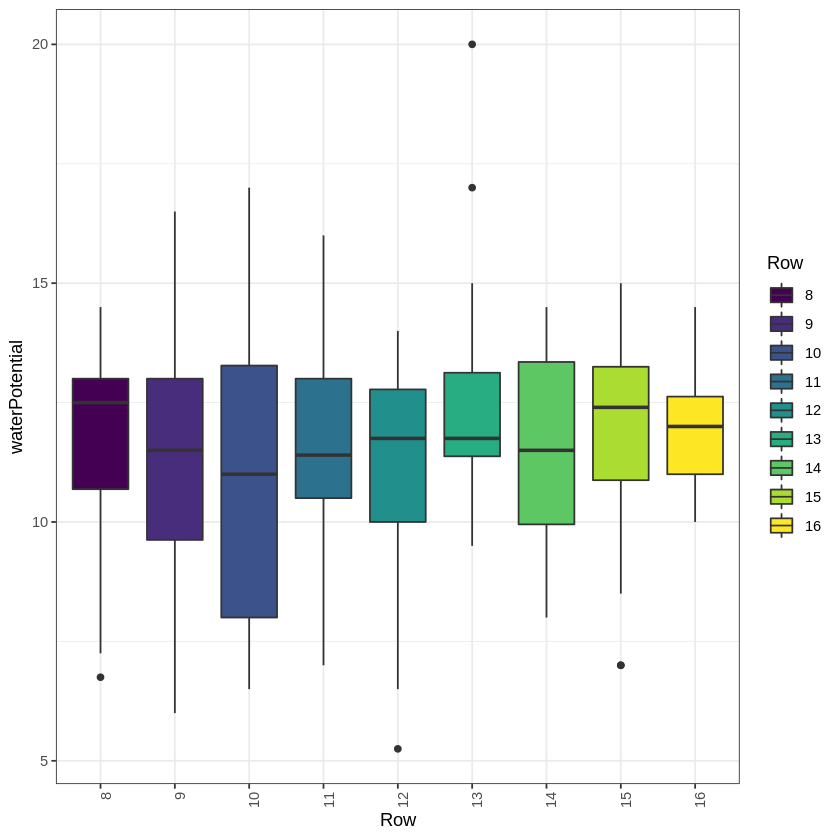

In [17]:
# row

row_pal <- viridisLite::viridis(9)

# get raw data
d <- df[,c('Row', 'sampleName', 'Block', 'Phenology', 'waterPotential')]

# remove outliers
d <- anomalize(as_tibble(d), target='waterPotential', method='iqr', alpha=0.03, max_anoms=0.1)
d <- d[d$anomaly != 'Yes',]
d <- d %>% mutate(Phenology = fct_relevel(Phenology, "anthesis", "veraison", "harvest"))
d$Row <- as.factor(d$Row)
p <- ggplot(d, aes_string(x='Row', y='waterPotential', fill='Row')) + 
     geom_boxplot() +
     scale_fill_manual(name='Row', values=row_pal) + #, labels=c('8', '2', '3', '4', '5', '6', '7', '8', '9')) +
     #scale_x_discrete(name='Row'), labels=c('1', '2', '3', '4', '5', '6', '7', '8', '9')) + 
     theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 0, hjust = 1)) + 
     theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1))
print(p)

Row,sampleName,Irrigation,Block,Phenology,waterPotential
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
8,A1Y1_001_L,none,A,anthesis,9.50
8,A1Y1_002_L,none,A,anthesis,12.50
8,A1Y1_003_L,none,A,anthesis,12.60
8,A1Y1_004_L,none,A,anthesis,10.50
8,A1Y1_005_L,none,A,anthesis,8.00
8,A1Y1_006_L,none,A,anthesis,10.75


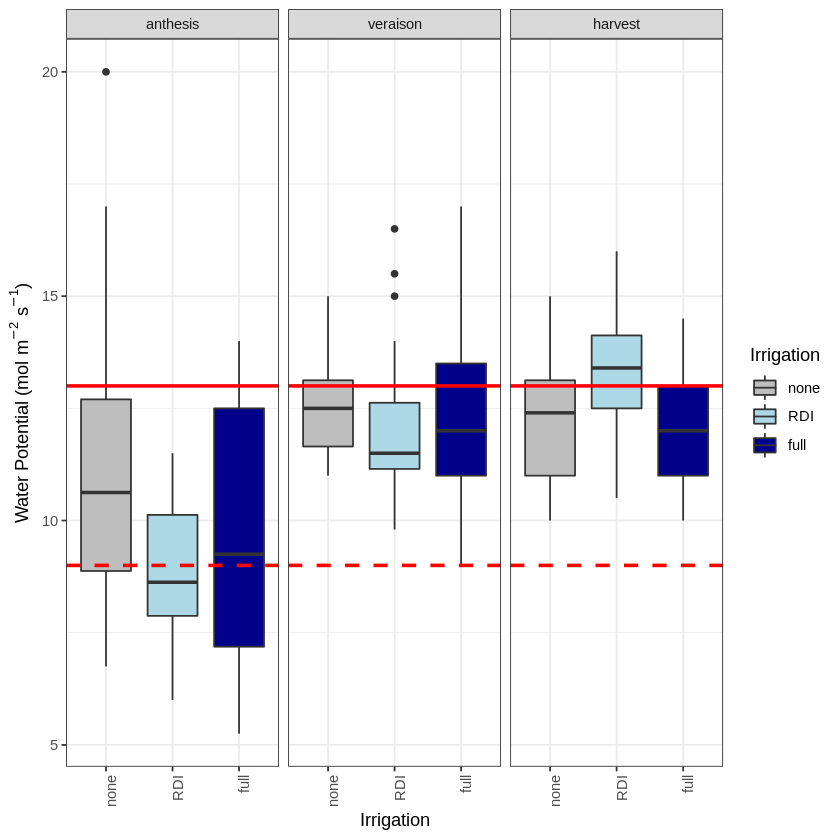

In [91]:
# row by phenology

row_pal <- viridisLite::viridis(9)
irr_c_pal <- c('grey', 'lightblue', 'darkblue')

# get raw data
d <- df[,c('Row', 'sampleName', 'Irrigation', 'Block', 'Phenology', 'waterPotential')]
head(d)
# remove outliers
d <- anomalize(as_tibble(d), target='waterPotential', method='iqr', alpha=0.03, max_anoms=0.1)
d <- d[d$anomaly != 'Yes',]
d <- d %>% mutate(Phenology = fct_relevel(Phenology, "anthesis", "veraison", "harvest")) %>%
           mutate(Irrigation=fct_relevel(Irrigation, 'none', 'RDI', 'full'))
d$Row <- as.factor(d$Row)
snFig1c <- ggplot(d, aes_string(x='Irrigation', y='waterPotential', fill='Irrigation')) + 
     geom_boxplot() +
     scale_fill_manual(name='Irrigation', values=irr_c_pal) + #, labels=c('1', '2', '3', '4', '5', '6', '7', '8', '9')) +
     #scale_x_discrete(name='Row', labels=c('1', '2', '3', '4', '5', '6', '7', '8', '9')) + 
     ylab(bquote('Water Potential ('*mol ~ m^-2 ~ s^-1*')')) + 
     geom_hline(yintercept=9, lty=2, size=1, color='red') + 
     geom_hline(yintercept=13, lty=1, color='red', size=1) +
     theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 0, hjust = 1)) + 
     facet_wrap('Phenology') + theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1))
print(snFig1c)

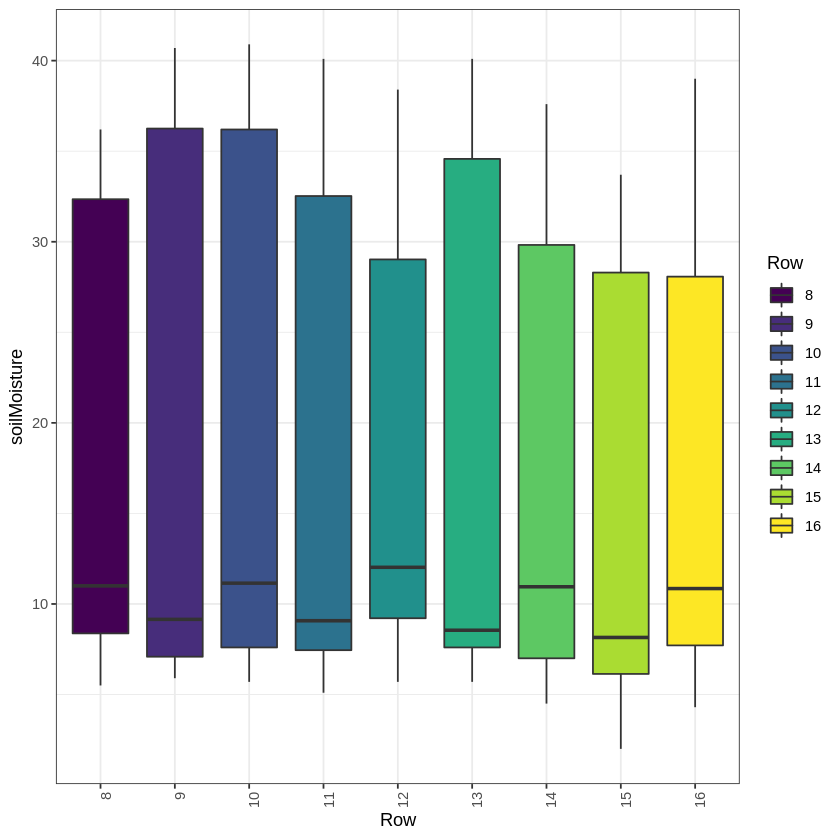

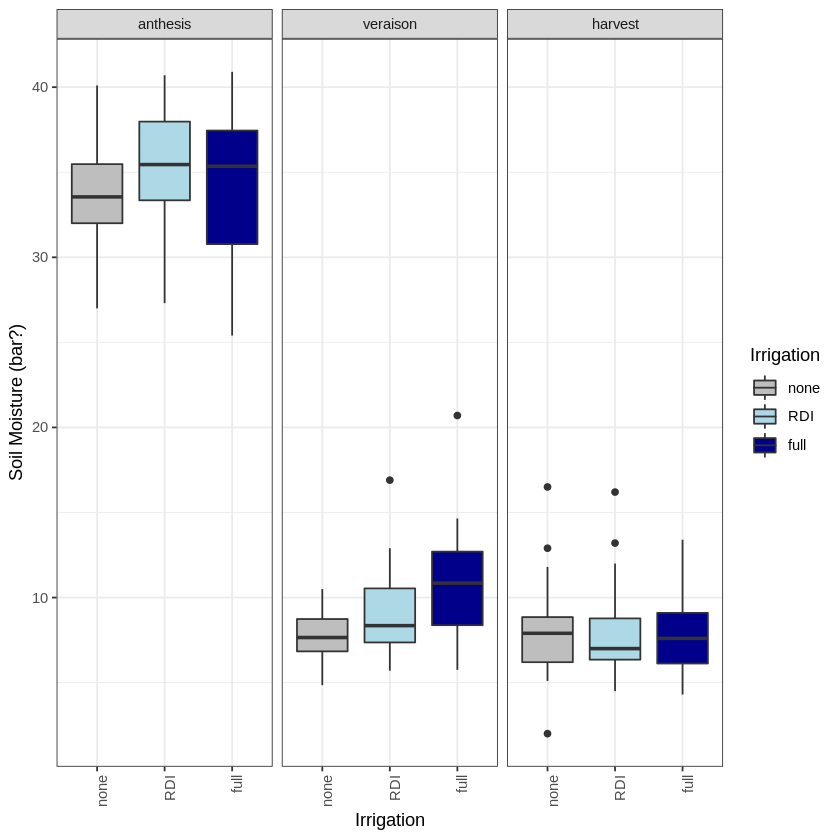

In [79]:
# get raw data
d <- df[,c('Row', 'Irrigation', 'sampleName', 'Block', 'Phenology', 'soilMoisture')]



# remove outliers
d <- anomalize(as_tibble(d), target='soilMoisture', method='iqr', alpha=0.03, max_anoms=0.1)
d <- d[d$anomaly != 'Yes',]
d <- d %>% mutate(Phenology = fct_relevel(Phenology, "anthesis", "veraison", "harvest")) %>%
           mutate(Irrigation=fct_relevel(Irrigation, 'none', 'RDI', 'full'))
d$Row <- as.factor(d$Row)

p <- ggplot(d, aes_string(x='Row', y='soilMoisture', fill='Row')) + 
     geom_boxplot() +
     scale_fill_manual(name='Row', values=row_pal) + 
     theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 0, hjust = 1)) + 
     theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1))
print(p)

snFig1a <- ggplot(d, aes_string(x='Irrigation', y='soilMoisture', fill='Irrigation')) + 
     geom_boxplot() +
     scale_fill_manual(name='Irrigation', values=irr_c_pal) + 
     ylab("Soil Moisture (bar?)") + 
     theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 0, hjust = 1)) + 
     facet_wrap('Phenology') + theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1))
print(snFig1a)

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

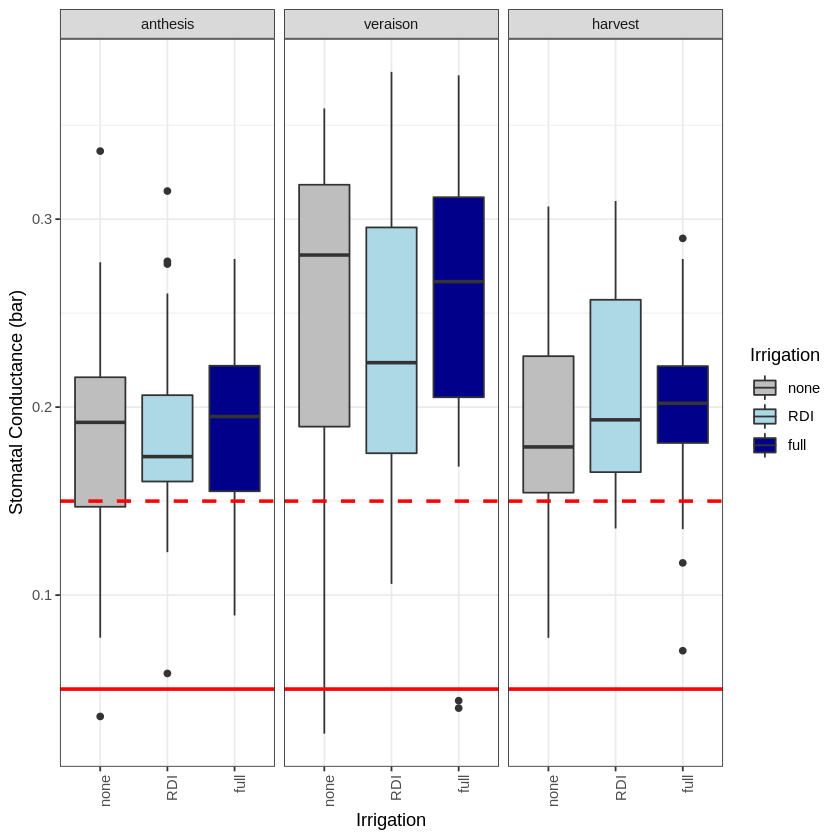

In [92]:
# row

row_pal <- viridisLite::viridis(9)

# get raw data
d <- df[,c('Row', 'Irrigation', 'sampleName', 'Block', 'Phenology', 'Cond')]

# remove outliers
d <- anomalize(as_tibble(d), target='Cond', method='iqr', alpha=0.03, max_anoms=0.1)
d <- d[d$anomaly != 'Yes',]
d <- d %>% mutate(Phenology = fct_relevel(Phenology, "anthesis", "veraison", "harvest")) %>%
           mutate(Irrigation=fct_relevel(Irrigation, 'none', 'RDI', 'full'))
d$Row <- as.factor(d$Row)
snFig1b <- ggplot(d, aes_string(x='Irrigation', y='Cond', fill='Irrigation')) + 
     geom_boxplot() +
     scale_fill_manual(name='Irrigation', values=irr_c_pal) + 
     ylab('Stomatal Conductance (bar)') + 
     geom_hline(yintercept=0.15, lty=2, color='red', size=1) + 
     geom_hline(yintercept=0.05, lty=1, color='red', size=1) +
     theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 0, hjust = 1)) + 
     theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     facet_wrap('Phenology')
print(snFig1b)

In [64]:
library(ggpubr)

Loading required package: magrittr

Attaching package: ‘magrittr’

The following object is masked from ‘package:rebus’:

    or

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

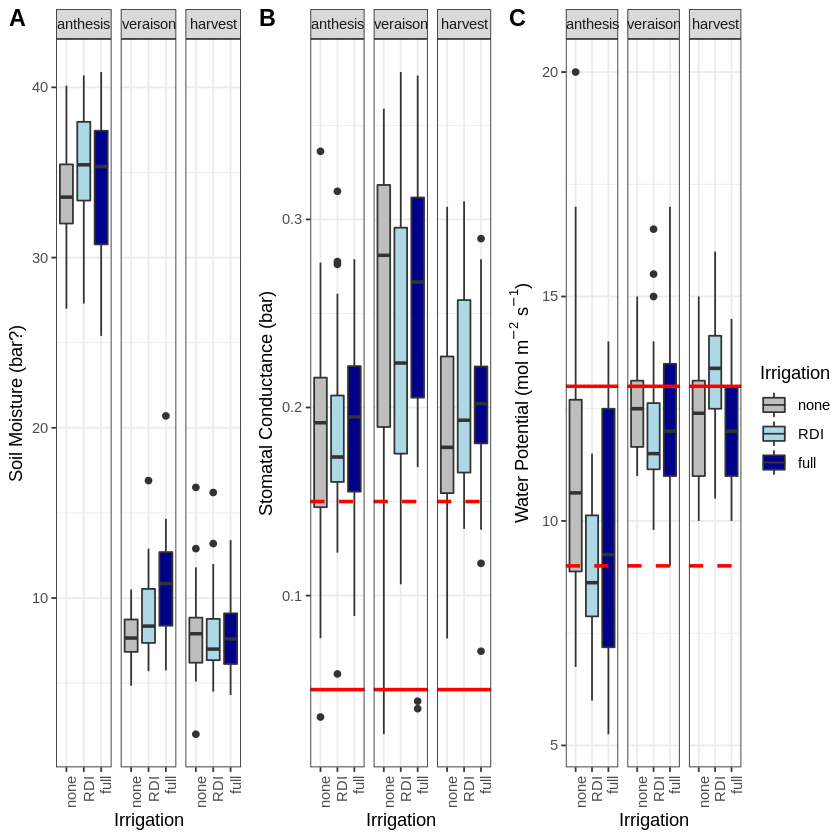

In [94]:
pdf('2017_irrigation_snFig1.pdf', width=12, height=4)
  ggarrange(snFig1a, snFig1b, snFig1c, labels=c('A', 'B', 'C'), common.legend=T, ncol=3, legend='right')
dev.off()

## Stats on Soil Moisture, Water Potential, and Stomatal Condunctance

In [31]:
d <- df %>% dplyr::select(sampleName, Irrigation, Rootstock, Phenology, Block, soilMoisture, Cond, waterPotential)

sM_model <- lm(soilMoisture ~ Irrigation + Block + Rootstock + Phenology + Irrigation:Block + Irrigation:Rootstock + Irrigation*Phenology + Rootstock:Block + Block:Phenology + Rootstock:Phenology, data=d, singular.ok=TRUE)
cond_model <- lm(Cond ~ Irrigation + Block + Rootstock + Phenology + Irrigation:Block + Irrigation:Rootstock + Irrigation*Phenology + Rootstock:Block + Block:Phenology + Rootstock:Phenology, data=d, singular.ok=TRUE)
wP_model <- lm(waterPotential ~ Irrigation + Block + Rootstock + Phenology + Irrigation:Block + Irrigation:Rootstock + Irrigation*Phenology + Rootstock:Block + Block:Phenology + Rootstock:Phenology, data=d, singular.ok=TRUE)

In [53]:
sM_anova <- car::Anova(sM_model, type=3)
cond_anova <- car::Anova(cond_model, type=3)
wP_anova <- car::Anova(wP_model, type=3)

sM_anova[sM_anova$Pr <= 0.05/3,]
cond_anova[cond_anova$Pr <= 0.05/3,]
wP_anova[wP_anova$Pr <= 0.05/3,]

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),7018.1239,1,930.250096,3.645488e-72
Block,187.2797,2,12.411930,9.064992e-06
Phenology,4282.0335,2,283.791093,8.475489e-56
Irrigation:Phenology,103.2899,4,3.422761,1.007782e-02
Block:Phenology,200.9982,4,6.660563,5.154667e-05
NA,NA,NA,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.18396991,1,48.129902,7.436822e-11
Phenology,0.06243231,2,8.166719,4.065630e-04
Block:Phenology,0.07966961,4,5.210757,5.460443e-04
Rootstock:Phenology,0.08123241,6,3.541981,2.465269e-03
NA,NA,NA,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),444.92459,1,126.484600,1.852656e-22
Irrigation,29.53735,2,4.198486,1.654937e-02
Phenology,102.14980,2,14.519738,1.456854e-06
Irrigation:Phenology,64.00449,4,4.548851,1.606969e-03
Block:Phenology,87.96463,4,6.251717,9.996488e-05
NA,NA,NA,NA,NA


In [49]:
sM.emm <- emmeans::emmeans(sM_model, ~Irrigation:Phenology)
res <- pairs(sM.emm)
res <- as.data.frame(res)
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = ",", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = ",", names = c('i2', 'p2')))
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.p1 == res$c2.p2,] %>% select(contrast:p.value)
res$padj <- p.adjust(res$p.value, method='fdr')
res[res$padj < 0.05,]

,contrast,estimate,SE,df,t.ratio,p.value,padj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
34,"full,veraison - none,veraison",3.197917,0.7929029,176,4.033175,0.002600176,0.02340158


In [51]:
wP.emm <- emmeans::emmeans(wP_model, ~Irrigation:Phenology)
res <- pairs(wP.emm)
res <- as.data.frame(res)
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = ",", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = ",", names = c('i2', 'p2')))
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.p1 == res$c2.p2,] %>% select(contrast:p.value)
res$padj <- p.adjust(res$p.value, method='fdr')
res[res$padj < 0.05,]

,contrast,estimate,SE,df,t.ratio,p.value,padj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,"none,anthesis - RDI,anthesis",2.266667,0.5414193,176,4.186527,0.001449736,0.01304763


In [35]:
head(df)

sampleName,Row,fileName,Rootstock,Irrigation,Phenology,Tissue,Block,block,vine,waterPotential,soilMoisture,Cond,Ci,Trmmol
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1Y1_001_L,8,A1Y1_001_L.counts,1103P,none,anthesis,Leaf,A,a,2,9.50,32.0,0.07734387,138.1123,0.9736491
A1Y1_002_L,8,A1Y1_002_L.counts,1103P,none,anthesis,Leaf,A,a,3,12.50,35.4,0.10386962,168.9603,1.1339703
A1Y1_003_L,8,A1Y1_003_L.counts,3309C,none,anthesis,Leaf,A,b,2,12.60,34.8,0.03543027,-147.5891,0.3974592
A1Y1_004_L,8,A1Y1_004_L.counts,3309C,none,anthesis,Leaf,A,b,3,10.50,35.4,0.33619481,258.1799,2.6348604
A1Y1_005_L,8,A1Y1_005_L.counts,SO4,none,anthesis,Leaf,A,c,2,8.00,33.4,0.12829633,166.6581,1.0702814
A1Y1_006_L,8,A1Y1_006_L.counts,SO4,none,anthesis,Leaf,A,c,3,10.75,33.4,0.27706389,281.0614,3.6145544


## Quick Plots for AJM

ERROR: Error in FUN(X[[i]], ...): object 'waterPotential' not found


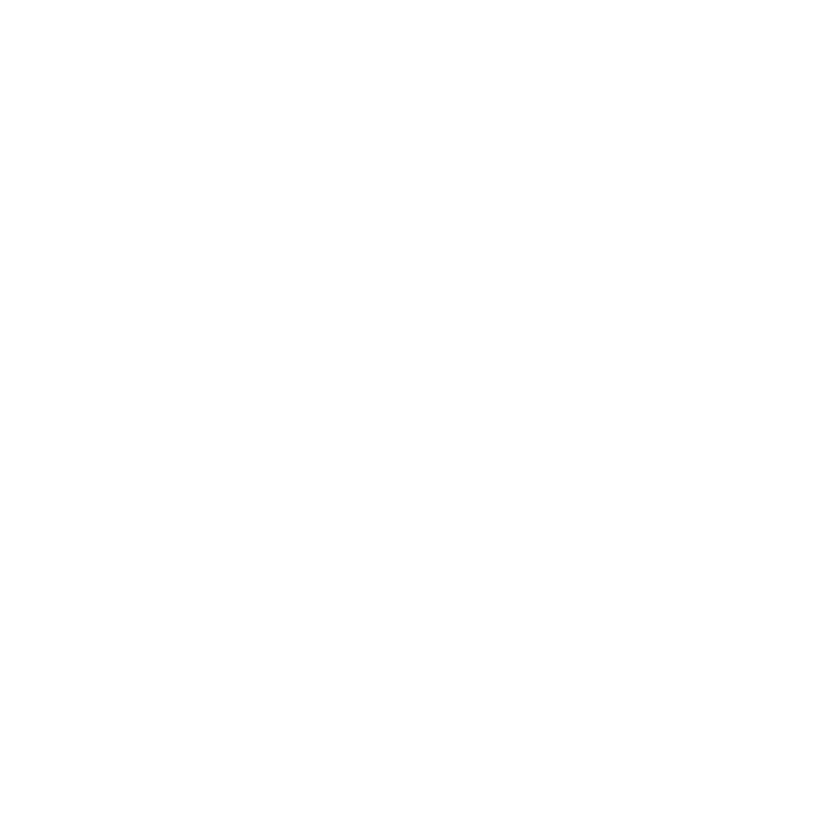

In [22]:
row_pal <- viridisLite::viridis(9)

# get raw data
d <- df[,c('sampleName', 'Rootstock', 'Phenology', 'Ci', 'Cond', 'Trmmol')]

# remove outliers
d <- anomalize(as_tibble(d), target='Ci', method='iqr', alpha=0.03, max_anoms=0.1)
d <- d[d$anomaly != 'Yes',]
d <- d %>% mutate(Phenology = fct_relevel(Phenology, "anthesis", "veraison", "harvest"))
p <- ggplot(d, aes_string(x='Rootstock', y='waterPotential', fill='Row')) + 
     geom_boxplot() +
     scale_fill_manual(name='Rootstock', values=rs_c_pal) + #, labels=c('8', '2', '3', '4', '5', '6', '7', '8', '9')) +
     #scale_x_discrete(name='Row'), labels=c('1', '2', '3', '4', '5', '6', '7', '8', '9')) + 
     theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 0, hjust = 1)) +  
     facet_wrap('Phenology') + theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1))


print(p)